# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
pd.set_option('display.width',500)
pd.set_option('display.float_format',lambda x :'%.3f' % x)
warnings.filterwarnings('ignore')

# Loading the data

In [2]:
train = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv",parse_dates=["date"])
test  = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/test.csv",parse_dates=["date"])
sample_sub = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv")
df = pd.concat([train,test],sort=False)

# EDA

In [3]:
df["date"].min(),df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [4]:
df["store"].nunique()

10

In [5]:
df["item"].nunique()

50

In [6]:
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.000,NaN
1,2013-01-02,1,1,11.000,NaN
2,2013-01-03,1,1,14.000,NaN
3,2013-01-04,1,1,13.000,NaN
4,2013-01-05,1,1,10.000,NaN


In [7]:
df.groupby(["store","item"]).nunique().head(10)

date  sales  id
store item                 
1     1     1916     41  90
      2     1916     90  90
      3     1916     59  90
      4     1916     39  90
      5     1916     34  90
      6     1916     86  90
      7     1916     83  90
      8     1916     98  90
      9     1916     72  90
      10    1916    100  90

In [8]:
df.groupby(["store","item"]).agg({"sales":["sum","mean","median","std"]}).head(10)


sales                     
                  sum   mean median    std
store item                                
1     1     36468.000 19.972 19.000  6.741
      2     97050.000 53.149 52.000 15.006
      3     60638.000 33.208 33.000 10.073
      4     36440.000 19.956 20.000  6.641
      5     30335.000 16.613 16.000  5.672
      6     96889.000 53.061 52.000 14.826
      7     96383.000 52.784 52.000 15.074
      8    126856.000 69.472 68.500 18.752
      9     84918.000 46.505 46.000 13.247
      10   121163.000 66.354 65.000 18.283

# FEATURE ENGINEERING


In [9]:
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.isocalendar().week
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = (df.date.dt.weekday >= 5).astype(int)
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    df["is_valentines_day"] = ((df.date.dt.month == 2) & (df.date.dt.day == 14)).astype(int)
    df["is_mothers_day"] = ((df.date.dt.month == 5) & (df.date.dt.day == 12)).astype(int)
    df["is_fathers_day"] = ((df.date.dt.month == 6) & (df.date.dt.day == 16)).astype(int)
    return df


In [10]:
df = create_date_features(df)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_valentines_day,is_mothers_day,is_fathers_day
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,0,0,0
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,0,0,0
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,0,0,0
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,0,0,0
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,0,0,0


In [11]:
df.groupby(["store","item","month"]).agg({"sales":["sum","mean","median","std"]}).head(12)


sales                    
                      sum   mean median   std
store item month                             
1     1    1     2125.000 13.710 13.000 4.397
           2     2063.000 14.631 14.000 4.668
           3     2728.000 17.600 17.000 4.545
           4     3118.000 20.787 20.000 4.894
           5     3448.000 22.245 22.000 6.565
           6     3725.000 24.833 24.000 6.231
           7     4025.000 25.968 25.000 6.737
           8     3492.000 22.529 22.000 5.888
           9     3208.000 21.387 20.500 5.797
           10    3045.000 19.645 20.000 5.832
           11    3205.000 21.367 21.000 5.580
           12    2286.000 14.748 14.000 4.886

# Random Noise

In [12]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6,size=(len(dataframe),))

# Lag/Shifted Features


In [13]:
df.sort_values(by=["store","item","date"],axis=0,inplace=True)

In [14]:
pd.DataFrame({"sales": df["sales"].values[0:10],# satışların gerçek 10 değerini getirdik
              "lag1": df["sales"].shift(1).values[0:10],# 1. gecikmeyi hesapladık
              "lag2": df["sales"].shift(2).values[0:10],# 2. gecikmeyi hesapladık
              "lag3": df["sales"].shift(3).values[0:10],# 3. gecikmeyi hesapladık
              "lag4": df["sales"].shift(4).values[0:10]})# 4. gecikmeyi hesapladık

,sales,lag1,lag2,lag3,lag4
0,13.000,NaN,NaN,NaN,NaN
1,11.000,13.000,NaN,NaN,NaN
2,14.000,11.000,13.000,NaN,NaN
3,13.000,14.000,11.000,13.000,NaN
4,10.000,13.000,14.000,11.000,13.000
5,12.000,10.000,13.000,14.000,11.000
6,10.000,12.000,10.000,13.000,14.000
7,9.000,10.000,12.000,10.000,13.000
8,12.000,9.000,10.000,12.000,10.000
9,9.000,12.000,9.000,10.000,12.000


In [15]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe) 
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182,185,190,195,200,250,300, 364, 546, 728])

In [16]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_valentines_day,is_mothers_day,is_fathers_day,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_185,sales_lag_190,sales_lag_195,sales_lag_200,sales_lag_250,sales_lag_300,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_valentines_day,is_mothers_day,is_fathers_day,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_185,sales_lag_190,sales_lag_195,sales_lag_200,sales_lag_250,sales_lag_300,sales_lag_364,sales_lag_546,sales_lag_728
44995,2018-03-27,10,50,NaN,44995.000,3,27,86,13,1,2018,0,0,0,0,0,0,41.568,54.330,66.425,66.820,68.051,80.724,80.529,100.009,61.339,83.650,99.140,94.887,99.351,61.592,98.202,71.566
44996,2018-03-28,10,50,NaN,44996.000,3,28,87,13,2,2018,0,0,0,0,0,0,62.853,49.010,66.368,61.389,74.200,80.480,80.982,98.216,85.499,89.322,93.120,129.011,116.501,73.073,79.088,68.964
44997,2018-03-29,10,50,NaN,44997.000,3,29,88,13,3,2018,0,0,0,0,0,0,60.446,62.047,72.825,63.625,72.816,90.711,83.299,61.085,72.526,93.436,96.072,117.093,98.293,69.406,100.043,73.673
44998,2018-03-30,10,50,NaN,44998.000,3,30,89,13,4,2018,0,0,0,0,0,0,74.552,74.808,69.518,67.560,65.893,81.038,89.584,75.401,89.557,98.374,72.971,141.199,98.095,69.790,77.896,83.471
44999,2018-03-31,10,50,NaN,44999.000,3,31,90,13,5,2018,1,0,1,0,0,0,61.272,68.649,51.673,70.940,49.530,76.990,104.610,84.372,96.433,109.275,70.902,82.083,124.408,101.934,95.572,83.557


# Rolling Mean Features

In [18]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "roll3": df["sales"].shift(1).rolling(window=3).mean().values[0:10],
              "roll5": df["sales"].shift(1).rolling(window=5).mean().values[0:10]})

,sales,roll2,roll3,roll5
0,13.000,NaN,NaN,NaN
1,11.000,NaN,NaN,NaN
2,14.000,12.000,NaN,NaN
3,13.000,12.500,12.667,NaN
4,10.000,13.500,12.667,NaN
5,12.000,11.500,12.333,12.200
6,10.000,11.000,11.667,12.000
7,9.000,11.000,10.667,11.800
8,12.000,9.500,10.333,10.800
9,9.000,10.500,10.333,10.600


In [19]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [150,200,250,365,400,450,546,600])

In [20]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_valentines_day,is_mothers_day,is_fathers_day,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_185,sales_lag_190,sales_lag_195,sales_lag_200,sales_lag_250,sales_lag_300,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_150,sales_roll_mean_200,sales_roll_mean_250,sales_roll_mean_365,sales_roll_mean_400,sales_roll_mean_450,sales_roll_mean_546,sales_roll_mean_600
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df.tail()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,is_valentines_day,is_mothers_day,is_fathers_day,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_185,sales_lag_190,sales_lag_195,sales_lag_200,sales_lag_250,sales_lag_300,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_150,sales_roll_mean_200,sales_roll_mean_250,sales_roll_mean_365,sales_roll_mean_400,sales_roll_mean_450,sales_roll_mean_546,sales_roll_mean_600
44995,2018-03-27,10,50,NaN,44995.000,3,27,86,13,1,2018,0,0,0,0,0,0,41.568,54.330,66.425,66.820,68.051,80.724,80.529,100.009,61.339,83.650,99.140,94.887,99.351,61.592,98.202,71.566,70.064,72.886,78.066,88.770,87.294,87.448,88.055,85.825
44996,2018-03-28,10,50,NaN,44996.000,3,28,87,13,2,2018,0,0,0,0,0,0,62.853,49.010,66.368,61.389,74.200,80.480,80.982,98.216,85.499,89.322,93.120,129.011,116.501,73.073,79.088,68.964,68.227,72.965,77.653,89.340,90.134,89.808,87.206,82.975
44997,2018-03-29,10,50,NaN,44997.000,3,29,88,13,3,2018,0,0,0,0,0,0,60.446,62.047,72.825,63.625,72.816,90.711,83.299,61.085,72.526,93.436,96.072,117.093,98.293,69.406,100.043,73.673,70.251,73.715,81.562,87.914,90.150,86.844,88.484,83.741
44998,2018-03-30,10,50,NaN,44998.000,3,30,89,13,4,2018,0,0,0,0,0,0,74.552,74.808,69.518,67.560,65.893,81.038,89.584,75.401,89.557,98.374,72.971,141.199,98.095,69.790,77.896,83.471,69.110,75.543,75.966,88.685,92.415,90.314,84.413,85.232
44999,2018-03-31,10,50,NaN,44999.000,3,31,90,13,5,2018,1,0,1,0,0,0,61.272,68.649,51.673,70.940,49.530,76.990,104.610,84.372,96.433,109.275,70.902,82.083,124.408,101.934,95.572,83.557,63.629,76.250,78.512,86.286,92.695,87.757,84.290,82.714


# Exponentially Weighted Mean Features


In [22]:
pd.DataFrame({"sales": df["sales"].values[0:10],
              "roll2": df["sales"].shift(1).rolling(window=2).mean().values[0:10],
              "ewm099": df["sales"].shift(1).ewm(alpha=0.99).mean().values[0:10],
              "ewm095": df["sales"].shift(1).ewm(alpha=0.95).mean().values[0:10],
              "ewm07": df["sales"].shift(1).ewm(alpha=0.7).mean().values[0:10],
              "ewm02": df["sales"].shift(1).ewm(alpha=0.1).mean().values[0:10]})

,sales,roll2,ewm099,ewm095,ewm07,ewm02
0,13.000,NaN,NaN,NaN,NaN,NaN
1,11.000,NaN,13.000,13.000,13.000,13.000
2,14.000,12.000,11.020,11.095,11.462,11.947
3,13.000,12.500,13.970,13.855,13.288,12.705
4,10.000,13.500,13.010,13.043,13.085,12.791
5,12.000,11.500,10.030,10.152,10.920,12.109
6,10.000,11.000,11.980,11.908,11.677,12.086
7,9.000,11.000,10.020,10.095,10.503,11.686
8,12.000,9.500,9.010,9.055,9.451,11.214
9,9.000,10.500,11.970,11.853,11.235,11.343


In [23]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [24]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]

In [25]:
lags = [91, 98, 105, 112, 180,200,250,270, 365, 546, 728]

In [26]:
df = ewm_features(df, alphas, lags)

# One-Hot Encoding


In [27]:
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])


# Converting sales to log(1+sales)


In [28]:
df["sales"] = np.log1p(df["sales"].values)

# Model


In [29]:
# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

# Time-Based Validation Sets


In [30]:
train = df.loc[(df["date"] < "2017-01-01"), :]


val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]


In [31]:
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [32]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape


((730500,), (730500, 167), (45000,), (45000, 167))

In [33]:
X_train.head()

,day_of_month,day_of_year,week_of_year,is_wknd,is_month_start,is_month_end,is_valentines_day,is_mothers_day,is_fathers_day,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_185,sales_lag_190,sales_lag_195,sales_lag_200,sales_lag_250,sales_lag_300,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_150,sales_roll_mean_200,sales_roll_mean_250,sales_roll_mean_365,sales_roll_mean_400,sales_roll_mean_450,sales_roll_mean_546,sales_roll_mean_600,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_200,sales_ewm_alpha_095_lag_250,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_200,sales_ewm_alpha_09_lag_250,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_200,sales_ewm_alpha_08_lag_250,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_200,sales_ewm_alpha_07_lag_250,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_200,sales_ewm_alpha_05_lag_250,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728,store_1,store_2,store_3,store_4,store_5,store_6,store_7,store_8,store_9,store_10,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,item_10,item_11,item_12,item_13,item_14,item_15,item_16,item_17,item_18,item_19,item_20,item_21,item_22,item_23,item_24,item_25,item_26,item_27,item_28,item_29,item_30,item_31,item_32,item_33,item_34,item_35,item_36,item_37,item_38,item_39,item_40,item_41,item_42,item_43,item_44,item_45,item_46,item_47,item_48,item_49,item_50,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1,1,1,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2,2,1,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

# LightGBM 

In [34]:
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 2000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [35]:
lgbtrain = lgb.Dataset(data=X_train,label=Y_train,feature_name=cols)
lgbval = lgb.Dataset(data=X_val,label=Y_val,reference=lgbtrain,feature_name=cols)

In [36]:
model = lgb.train(lgb_params,lgbtrain,
                 valid_sets=[lgbtrain,lgbval],
                 num_boost_round=lgb_params['num_boost_round'],
                 feval=lgbm_smape)

In [37]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.609212140237688

# Feature Importance

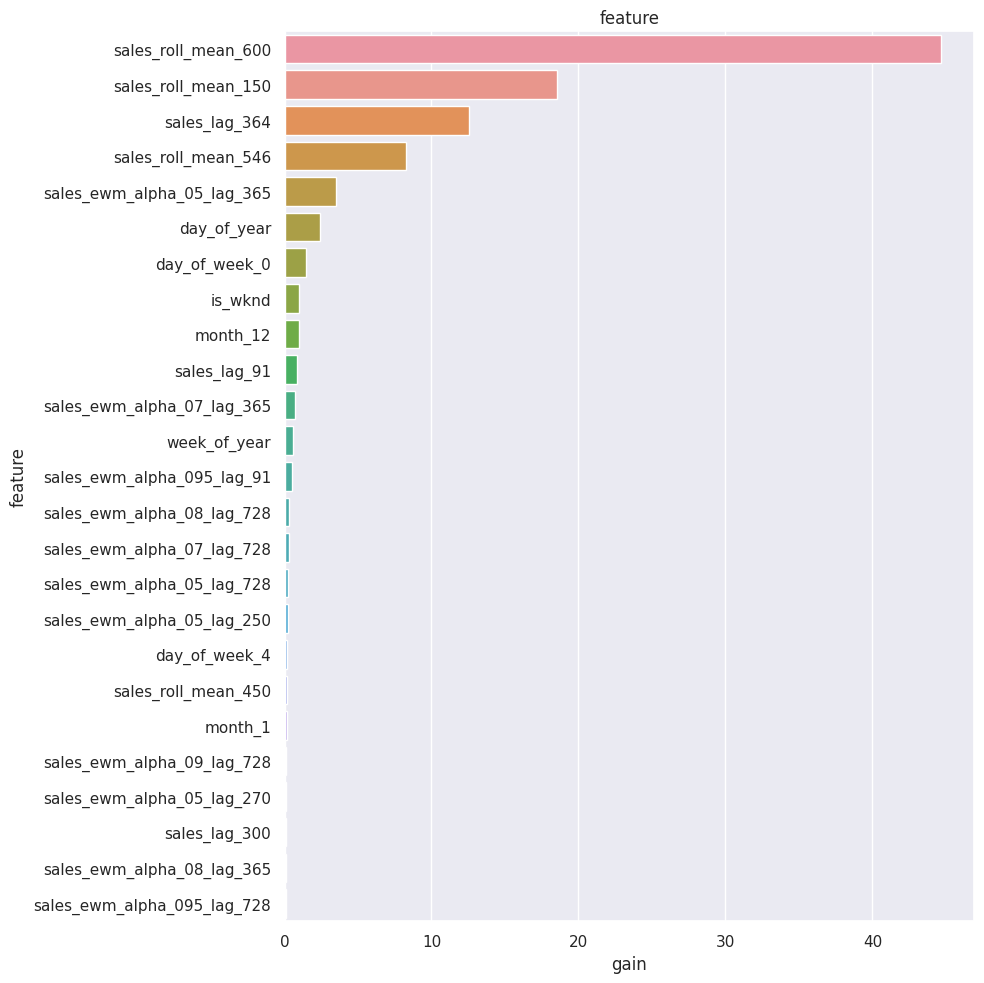

,feature,split,gain
32,sales_roll_mean_600,940,44.677
25,sales_roll_mean_150,644,18.537
22,sales_lag_364,2552,12.549
31,sales_roll_mean_546,636,8.268
85,sales_ewm_alpha_05_lag_365,410,3.480
1,day_of_year,1387,2.397
148,day_of_week_0,429,1.471
3,is_wknd,282,1.015
166,month_12,493,1.008
9,sales_lag_91,208,0.853


In [38]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=30, plot=True)